In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
from qasvm.circuits.classifier import QASVM, BlochSphereQASVM, UniformQASVM, UniformBlochQASVM
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.ibmqbackend import IBMQBackend
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.test.mock import FakeMontreal
import numpy as np

In [3]:
from qasvm.datasets import Toy2DLinearLoader, Sklearn_DataLoader, Toy2DXORLoader, ToyBlochSphereLoader
from qasvm.preprocessing import DataMultiScaler, DataScaler
from qasvm.classifier import BinarySVM
from qasvm.kernel import Kernel
from sklearn.datasets import make_circles, make_moons, load_breast_cancer
import numpy as np 
from matplotlib import pyplot as plt

In [4]:
from qiskit.aqua.components.optimizers.spsa import logger as spsa_logger
import logging
file_handler = logging.FileHandler('./logging.log')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
spsa_logger.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
spsa_logger.addHandler(file_handler)

In [5]:
import importlib
#importlib.import_module(SPSA().__module__).__getattribute__('logger')

# Variational Form: Real Amplitude

In [6]:
var_form = RealAmplitudes(2, reps=5)
var_form.draw()

┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐     »
q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2]) ├──■──┤ RY(θ[4]) ├──■──┤ RY(θ[6]) ├──■──»
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐»
q_1: ┤ RY(θ[1]) ├┤ X ├┤ RY(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ X ├┤ RY(θ[7]) ├┤ X ├»
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘└───┘»
«     ┌──────────┐     ┌───────────┐
«q_0: ┤ RY(θ[8]) ├──■──┤ RY(θ[10]) ├
«     ├──────────┤┌─┴─┐├───────────┤
«q_1: ┤ RY(θ[9]) ├┤ X ├┤ RY(θ[11]) ├
«     └──────────┘└───┘└───────────┘

# Feature Map: U3

In [7]:
feature_map = TwoLocal(1, ['ry', 'rz'], skip_final_rotation_layer=True, reps=1)
feature_map.draw()

┌──────────┐┌──────────┐
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[1]) ├
     └──────────┘└──────────┘

# Set Dataset

In [8]:
np.random.seed(0)
dl = ToyBlochSphereLoader(gap = np.pi/4)
X, y = dl(2**2, noise=0.0)

# Imitation of QASVM

accuracy: 1.0


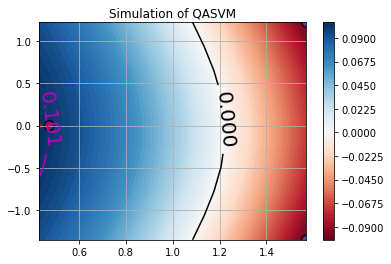

In [9]:
svm = BinarySVM(Kernel('SingleQubit'), C=None, k=0.1, mutation='REDUCED_QASVM')
svm.fit(X, y)
svm.plot_boundary()
plt.title('Simulation of QASVM')
print(f'accuracy: {svm.accuracy(X, y)}')


# Variational Algorithm QASVM

In [10]:
optimizer = SPSA(maxiter=2**13, last_avg=2**9)
quantum_instance = QuantumInstance(backend=QasmSimulator(), shots=2**18)
#qasvm = QASVM(var_form=var_form, feature_map=feature_map, optimizer=optimizer, training_data=X, training_label=y, C=None, k=0.1, quantum_instance=quantum_instance).dual
qasvm = BlochSphereQASVM(var_form=var_form, optimizer=optimizer, training_data=X, training_label=y, quantum_instance=quantum_instance, C=1, k=0.1).primal

In [11]:
qasvm.run()
qasvm.accuracy(X, y)

1.0

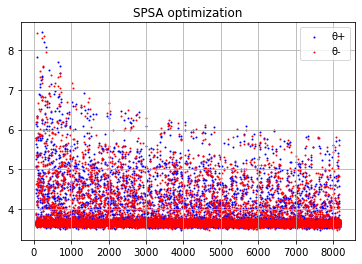

In [12]:
from qasvm.circuits.visualization import Plot_Log_From_SPSA
Plot_Log_From_SPSA('./logging.log').plot(min_step = 50, s=0.1)

In [13]:
from itertools import product
sum([svm.alpha[i]*svm.alpha[j]*svm.polary[i]*svm.polary[j]*(svm.kernel(X[i], X[j])+1/svm.k) for i, j in product(range(4), range(4))])

0.10139233459948521

In [14]:
qasvm.f(X)

array([-0.08856201, -0.09046173,  0.11032104,  0.11462402])

In [15]:
svm.f(X)

array([-0.10139233, -0.10139233,  0.10139233,  0.10409706])

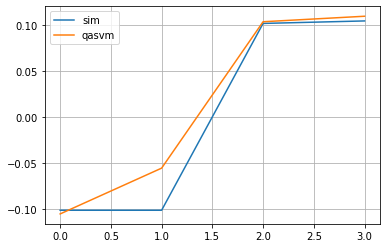

In [16]:
plt.plot(svm.f(X), label='sim')
plt.plot(qasvm.f(X), label='qasvm')
plt.legend()
plt.grid()

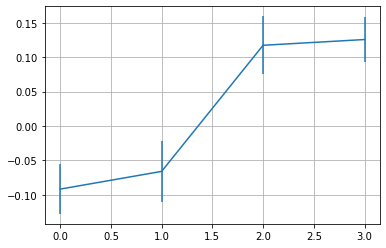

In [17]:
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0))
plt.grid()

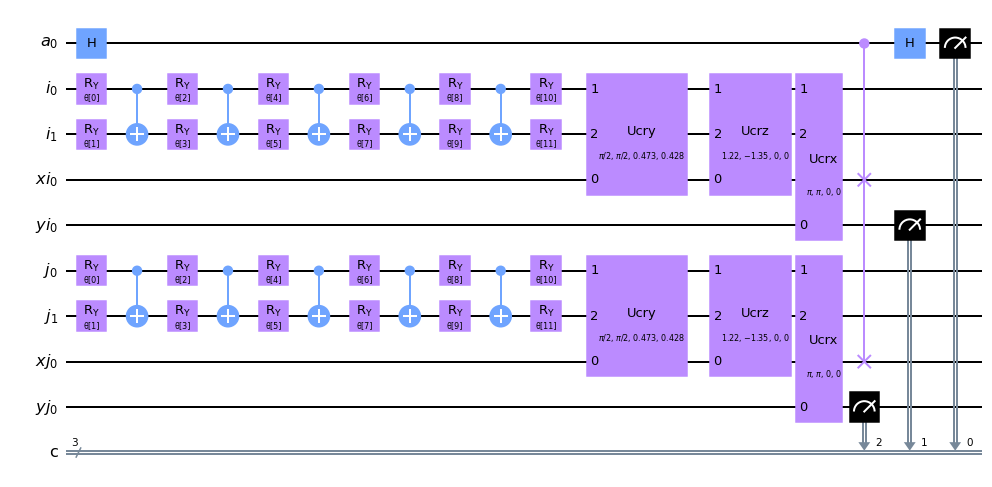

In [18]:
qasvm.second_order_circuit.draw('mpl')

In [19]:
qasvm.result.optimal_value

3.6465415954589844